#  HQI 사용자 가이드 - TEAM TEN (TT)

### 모듈 import
케라스를 사용하려면 텐서플로 프레임워크가 설치된 상태에서 install 해야함

In [1]:
import cv2, os, glob
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, Activation, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from skimage.transform import pyramid_expand
from Subpixel import Subpixel
from DataGenerator import DataGenerator
from keras.models import load_model
from keras.models import Sequential
import matplotlib.pyplot as plt


Using TensorFlow backend.


### 전처리된 이미지의 numpy 리스트를 불러옴
- 본인의 이미지 저장위치의 base를 base_path에 넣어주면 됨

In [2]:
base_path = r'C:/Users/ByeongHyeon/Desktop/opensource/celeba-dataset/processed'

x_train_list = sorted(glob.glob(os.path.join(base_path + '/' + 'x_train', '*.npy')))
# grob.grob -> 해당 주소들을 리스트로 저장
x_val_list = sorted(glob.glob(os.path.join(base_path + '/' + 'x_val', '*.npy')))
# print(os.path.join(base_path + '/' + 'x_train', '*.npy'))
# print(len(x_train_list), len(x_val_list))
# print(x_train_list[0])

(44, 44, 3) (44, 44, 3)


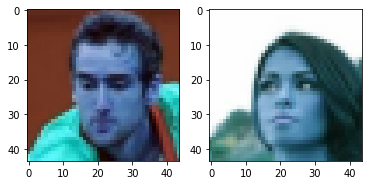

In [4]:
x1 = np.load(x_train_list[0])
# 배열 로드
x2 = np.load(x_val_list[0])

print(x1.shape, x2.shape)

plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.subplot(1, 2, 2)
plt.imshow(x2)

### train set, validation set load

In [5]:
train_gen = DataGenerator(list_IDs=x_train_list, labels=None, batch_size=16, dim=(44,44), n_channels=3, n_classes=None, shuffle=True)

val_gen = DataGenerator(list_IDs=x_val_list, labels=None, batch_size=16, dim=(44,44), n_channels=3, n_classes=None, shuffle=False)


저장될 모델 경로

In [6]:
modelpath = r'C:/Users/ByeongHyeon/Desktop/opensource/super_resolution-master/super_resolution-master/models/model_o.h5'

### CNN (convolutional neural network)  with Subpixel

In [4]:
upscale_factor = 4

inputs = Input(shape=(44, 44, 3))

net = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
net = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Dropout(0.5)(net)
net = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Dropout(0.5)(net)
net = Conv2D(filters=upscale_factor**2, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Subpixel(filters=3, kernel_size=3, r=upscale_factor, padding='same')(net)
outputs = Activation('relu')(net)

model = Model(inputs=inputs, outputs=outputs)
#model = load_model(modelpath)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 44, 44, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        18464     
_________________________________________________________________
dropout_2 (Dropout)          (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 16)        4624

### 모델 학습, 만약 이 부분을 스킵하고 싶다면 아래에서 weight을 load하여 사용하면 됨

In [9]:
history = model.fit_generator(train_gen, validation_data=val_gen, epochs=50, verbose=1, callbacks=[
    ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
])

Epoch 1/50
62/62 [==============================] - 78s 1s/step - loss: 0.0552 - val_loss: 0.0178

Epoch 00001: val_loss improved from inf to 0.01782, saving model to C:/Users/ByeongHyeon/Desktop/opensource/super_resolution-master/super_resolution-master/models/model_o.h5
Epoch 2/50
62/62 [==============================] - 51s 822ms/step - loss: 0.0174 - val_loss: 0.0186

Epoch 00002: val_loss did not improve from 0.01782
Epoch 3/50
62/62 [==============================] - 52s 835ms/step - loss: 0.0123 - val_loss: 0.0086

Epoch 00003: val_loss improved from 0.01782 to 0.00858, saving model to C:/Users/ByeongHyeon/Desktop/opensource/super_resolution-master/super_resolution-master/models/model_o.h5
Epoch 4/50
62/62 [==============================] - 52s 838ms/step - loss: 0.0097 - val_loss: 0.0083

Epoch 00004: val_loss improved from 0.00858 to 0.00829, saving model to C:/Users/ByeongHyeon/Desktop/opensource/super_resolution-master/super_resolution-master/models/model_o.h5
Epoch 5/50
62/

### 결과 플로팅

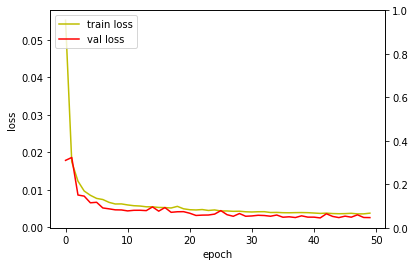

In [10]:
history.history['loss']
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
hist = history
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

#acc_ax.plot(hist.history['acc'], 'b', label='train acc')
#acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
#acc_ax.set_ylabel('accuracy')
#acc_ax.legend(loc='upper left')

plt.show()

In [11]:
## 레이어 확인
for layer in model.layers:
    print(layer.output_shape)

(None, 44, 44, 3)
(None, 44, 44, 64)
(None, 44, 44, 64)
(None, 44, 44, 64)
(None, 44, 44, 32)
(None, 44, 44, 32)
(None, 44, 44, 16)
(None, 176, 176, 3)
(None, 176, 176, 3)


### 학습 모델 save
- 이부분은 잘못 세이브 하면 기존 모델이 날아가기 때문에 주석처리

In [12]:
#model.save_weights("model_weights_dropout.h5")

### 모델 weight load 위의 학습 부분을 건너뛰고 해도됨

In [5]:
#model2 = Model()
model.load_weights("model_weights_dropout.h5")
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 44, 44, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        18464     
_________________________________________________________________
dropout_2 (Dropout)          (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 16)        4624

In [14]:
x_test_list = sorted(glob.glob(os.path.join(base_path+'/'+ 'x_val', '*.npy')))
y_test_list = sorted(glob.glob(os.path.join(base_path+'/'+ 'y_val', '*.npy')))
# x_train_list = sorted(glob.glob(os.path.join(base_path + '/' + 'x_train', '*.npy')))
# # grob.grob -> 해당 주소들을 리스트로 저장
# x_val_list = sorted(glob.glob(os.path.join(base_path + '/' + 'x_val', '*.npy')))
print(os.path.join(base_path+'/'+ 'x_test', '*.npy'))
print(len(x_test_list), len(y_test_list))
print(x_test_list[0])

C:/Users/ByeongHyeon/Desktop/opensource/celeba-dataset/processed/x_test\*.npy
1000 1000
C:/Users/ByeongHyeon/Desktop/opensource/celeba-dataset/processed/x_val\164317.npy


In [15]:
test_idx = 100

x1_test = np.load(x_test_list[test_idx])
x1_test_resized = pyramid_expand(x1_test, 4)
y1_test = np.load(y_test_list[test_idx])
y_pred = model.predict(x1_test.reshape((1, 44, 44, 3)))

print(x1_test.shape, y1_test.shape)
print(y_pred.shape)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


(44, 44, 3) (176, 176, 3)
(1, 176, 176, 3)


In [16]:
import os, cv2, glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import pyramid_reduce 
#plt.style.use('dark_background')

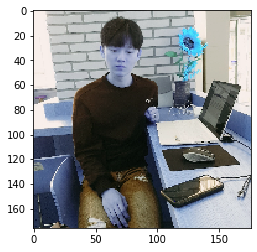

In [22]:
bh = np.load("hsbh.npy")
bh.shape
# plt.
plt.imshow(bh)

### test set에서의 확인 이 경우가 best fit  다른 사이즈의 저화질 이미지가 들어오면 성능이 나쁠 수 있음

(44, 44, 3) (176, 176, 3)


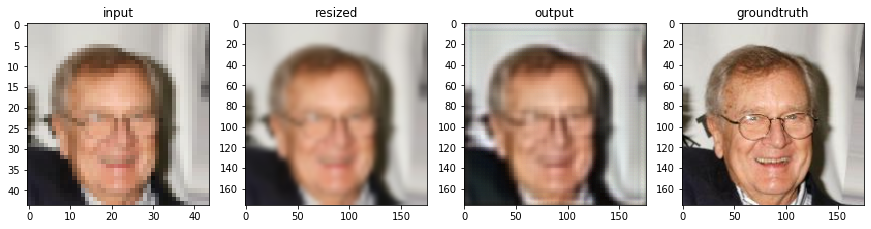

In [18]:
test_idx = 200

x1_test = np.load(x_test_list[test_idx])
x1_test_resized = pyramid_expand(x1_test, 4)
y1_test = np.load(y_test_list[test_idx])
y_pred = model.predict(x1_test.reshape((1, 44, 44, 3)))

print(x1_test.shape, y1_test.shape)

x1_test = (x1_test * 255).astype(np.uint8)
x1_test_resized = (x1_test_resized * 255).astype(np.uint8)
y1_test = (y1_test * 255).astype(np.uint8)
y_pred = np.clip(y_pred.reshape((176, 176, 3)), 0, 1)

x1_test = cv2.cvtColor(x1_test, cv2.COLOR_BGR2RGB)
x1_test_resized = cv2.cvtColor(x1_test_resized, cv2.COLOR_BGR2RGB)
y1_test = cv2.cvtColor(y1_test, cv2.COLOR_BGR2RGB)
y_pred = cv2.cvtColor(y_pred, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(x1_test)
plt.subplot(1, 4, 2)
plt.title('resized')
plt.imshow(x1_test_resized)
plt.subplot(1, 4, 3)
plt.title('output')
plt.imshow(y_pred)
plt.subplot(1, 4, 4)
plt.title('groundtruth')
plt.imshow(y1_test)

### 본인 사진을 통한 실제 모델 적용
- 기본 경로는 파일과 같은 곳에 이미지를 두고 실행하여야 함
- 절대 경로로 지정해도됨

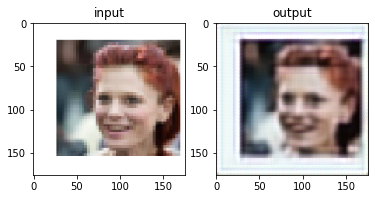

In [6]:
downscale = 4



def img_predict(img_path):
    img= cv2.imread(img_path)
    h, w, _ = img.shape
    crop = img[int((h-w)/2):int(-(h-w)/2), :]
    # 178 178 3
    crop = cv2.resize(crop, dsize=(176, 176))
    # 176 176 3
    just_resize = cv2.resize(img, dsize=(44,44))
    just_norm = cv2.normalize(just_resize.astype(np.float64), None, 0, 1, cv2.NORM_MINMAX)
    img = cv2.resize(img, dsize=(176, 176))
    y_pred = model.predict(just_norm.reshape((1, 44, 44, 3)))
    y_pred = np.clip(y_pred.reshape((176, 176, 3)), 0, 1)
    y_pred = cv2.cvtColor(y_pred, cv2.COLOR_BGR2RGB) #cv2로 저장하고 plt로 imshow를 하기 떄문에 이미지의 조정이 필요(아니면 색깔반전)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, 1)
    plt.title('input')
    
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.title("output")
    plt.imshow(y_pred)

img_path = "resized.png"
img_predict(img_path)  
